<a href="https://colab.research.google.com/github/mohannn-sys/ColposcopyImageSegmentation/blob/main/Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pickle
import cv2
import joblib
import glob
import numpy as np
import os

In [ ]:
model = joblib.load('/content/drive/MyDrive/rForestmodel.pkl')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def extract_countours_from_actual(mask_image_path):
  mask_image = cv2.imread(mask_image_path, cv2.IMREAD_GRAYSCALE)

  # Apply Canny edge detection
  edges = cv2.Canny(mask_image, 50, 150)

  # Find contours
  contours, _ = cv2.findContours(mask_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

  # Find top 3 contours with largest perimeter
  largest_contours = []
  perimeters = []
  for contour in contours:
      perimeter = cv2.arcLength(contour, True)
      perimeters.append(perimeter)

  perimeters_sorted_indices = sorted(range(len(perimeters)), key=lambda i: perimeters[i], reverse=True)[:3]

  for idx in perimeters_sorted_indices:
      largest_contours.append(contours[idx])

  # Draw the largest contours on a blank image (if you want to visualize)
  result_image = cv2.cvtColor(mask_image, cv2.COLOR_GRAY2BGR)  # Convert mask to color image
  cv2.drawContours(result_image, largest_contours, -1, (0, 255, 0), 2)
  return largest_contours, result_image

In [ ]:
def extract_regions_from_predicted(predicted_mask, largest_countours):
  #second_mask_image = cv2.imread('/content/drive/MyDrive/TrainingData/Image/AAHB5.jpg', cv2.IMREAD_GRAYSCALE)
  second_mask_image = predicted_mask

  # Create a blank image of the same size as the second mask image
  resultant_image = np.zeros_like(second_mask_image)

  # Draw the contours of the three regions from the first mask onto the blank image
  cv2.drawContours(resultant_image, largest_countours, -1, (255), thickness=cv2.FILLED)

  # Apply the combined mask to the second mask image
  resultant_image = cv2.bitwise_and(second_mask_image, second_mask_image, mask=resultant_image)

  return resultant_image

In [ ]:
test_image_folder = '/content/drive/MyDrive/TestingData/Image'
test_mask_folder = '/content/drive/MyDrive/TestingData/Mask'

# Get sorted lists of image and mask files
test_image_files = sorted(glob.glob(os.path.join(test_image_folder, '*.jpg')))
test_mask_files = sorted(glob.glob(os.path.join(test_mask_folder, '*.png')))

# Load and preprocess images and masks
X_test = []
y_test = []

for image_file, mask_file in zip(test_image_files[0], test_mask_files[0]):
    # Load image
    img = cv2.imread(image_file)
    # Normalize pixel values to [0, 1]
    #img_array = cv2.resize(img_array, (512, 512))  # Resize to (256, 256, 3)


    # Load mask
    mask = cv2.imread(mask_file, 0)  # Load as grayscale
    countours = extract_countours_from_actual(mask_file)
    # Resize mask to (256, 256, 1)
    #mask_array = cv2.resize(mask_array, (512, 512))
    mask_array = np.expand_dims(mask_array, axis=-1)  # Add a channel dimension
    # Apply threshold to create binary mask
    threshold = 0.5  # Adjust threshold if needed
    mask_array = np.where(mask_array > threshold, 1, 0)  # Set pixels above threshold to 1

    flattened_image = img_array.reshape(-1, 3)
    binary_mask = mask_array.ravel()

    # Predict the mask
    pred_mask_flattened = model.predict(flattened_image)
    pred_mask = pred_mask_flattened.reshape((600, 800))
    extracted_reg = extract_regions_from_predicted(pred_mask, countours)
    display(extracted_reg)

In [ ]:
img = cv2.imread('/content/drive/MyDrive/TrainingData/Image/AAAP6 (1).jpg')
# Normalize pixel values to [0, 1]
#img_array = cv2.resize(img_array, (512, 512))  # Resize to (256, 256, 3)


# Load mask
mask = cv2.imread('/content/drive/MyDrive/TrainingData/Mask/AAAP6 (1).png', 0)  # Load as grayscale
countours, mask1 = extract_countours_from_actual('/content/drive/MyDrive/TrainingData/Mask/AAAP6 (1).png')
# Resize mask to (256, 256, 1)
#mask_array = cv2.resize(mask_array, (512, 512))
#mask_array = np.expand_dims(mask_array, axis=-1)  # Add a channel dimension
# Apply threshold to create binary mask
threshold = 0.5  # Adjust threshold if needed
mask_array = np.where(mask > 127, 1, 0)  # Set pixels above threshold to 1

flattened_image = img.reshape(-1, 3)
binary_mask = mask_array.ravel()

# Predict the mask
pred_mask_flattened = model.predict(flattened_image)
pred_mask = pred_mask_flattened.reshape((600, 800))
extracted_reg = extract_regions_from_predicted(pred_mask, countours)
display(img)
display(pred_mask)
display(mask1)
display(extracted_reg)

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

# Calculate the confusion matrix
conf_matrix = confusion_matrix(mask_array.ravel(), extracted_reg.ravel())
print(conf_matrix)


[[409969      0   1901]
 [  9902      0  58228]
 [     0      0      0]]


In [ ]:
# Calculate and print the classification report
print(classification_report(mask_array.ravel(), extracted_reg.ravel()))

In [ ]:
# Calculate and print class-wise IoU
iou = (conf_matrix.diagonal() / (conf_matrix.sum(axis=1) + conf_matrix.sum(axis=0) - conf_matrix.diagonal()))
print("Class-wise IoU:", iou)

Class-wise IoU: [0.97201569 0.         0.        ]


In [ ]:
img = cv2.imread('/content/drive/MyDrive/TrainingData/Image/AAAP6 (1).jpg')
# Normalize pixel values to [0, 1]
#img_array = cv2.resize(img_array, (512, 512))  # Resize to (256, 256, 3)


# Load mask
mask = cv2.imread('/content/drive/MyDrive/TrainingData/Mask/AAAP6 (1).png', 0)  # Load as grayscale
countours, mask1 = extract_countours_from_actual('/content/drive/MyDrive/TrainingData/Mask/AAAP6 (1).png')
# Resize mask to (256, 256, 1)
#mask_array = cv2.resize(mask_array, (512, 512))
#mask_array = np.expand_dims(mask_array, axis=-1)  # Add a channel dimension
# Apply threshold to create binary mask
mask_array = np.where(mask > 127, 1, 0)  # Set pixels above threshold to 1
binary_mask = mask_array.ravel()

extracted_reg = extract_regions_from_predicted(img, countours)
extracted_reg = extracted_reg.reshape(-1, 3)

# Predict the mask
pred_mask_flattened = model.predict(extracted_reg)
pred_mask = pred_mask_flattened.reshape((600, 800))
display(img)
display(pred_mask)
display(mask1)
display(extracted_reg)

In [ ]:
def extract_top_contours(mask_image):
    if len(mask_image.shape) != 2:
        mask_image = cv2.cvtColor(mask_image, cv2.COLOR_BGR2GRAY)

    # Apply Canny edge detection
    edges_image = cv2.Canny(mask_image, 50, 150)

    # Find contours
    contours, _ = cv2.findContours(mask_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Find top 3 contours with the largest perimeter
    largest_contours = []
    contour_perimeters = [cv2.arcLength(contour, True) for contour in contours]
    sorted_contour_indices = sorted(range(len(contour_perimeters)), key=lambda i: contour_perimeters[i], reverse=True)[:3]

    # Select the largest contours
    largest_contours = [contours[idx] for idx in sorted_contour_indices]

    # Draw the largest contours on a blank image for visualization
    result_image = cv2.cvtColor(mask_image, cv2.COLOR_GRAY2BGR)
    cv2.drawContours(result_image, largest_contours, -1, (20, 250, 245), 2)

    return largest_contours, result_image


def apply_region_mask(image, largest_contours):
    # Create a blank mask image with the same dimensions as the input image
    mask_to_apply = np.zeros_like(image)

    # Draw the contours of the largest regions onto the blank mask image
    cv2.drawContours(mask_to_apply, largest_contours, -1, (255, 255, 255), thickness=cv2.FILLED)

    # Apply the combined mask to the input image
    resultant_image = cv2.bitwise_and(image, mask_to_apply)

    return resultant_image


In [ ]:
img = cv2.imread('/content/drive/MyDrive/TestingData/Image/AAIG2.jpg')

# Load mask
mask = cv2.imread('/content/drive/MyDrive/TestingData/Mask/AAIG2.png', cv2.IMREAD_GRAYSCALE)  # Load as grayscale

mask_array = np.where(mask > 127, 255, 0)
countours, mask1 = extract_top_contours(mask_array.astype(np.uint8))

extracted_reg = apply_region_mask(img, countours)

flattened_img = extracted_reg.reshape(-1, 3)
binary_mask = mask_array.ravel()

# Predict the mask
pred_mask_flattened = model.predict(flattened_img)
pred_mask = pred_mask_flattened.reshape((600, 800))

array([[[254, 255, 255],
        [254, 255, 255],
        [255, 255, 255],
        ...,
        [254, 254, 252],
        [255, 255, 255],
        [254, 254, 254]],

       [[227, 227, 225],
        [227, 227, 225],
        [228, 227, 225],
        ...,
        [250, 249, 245],
        [255, 255, 253],
        [255, 255, 255]],

       [[147, 144, 139],
        [148, 145, 140],
        [148, 143, 139],
        ...,
        [231, 226, 220],
        [255, 254, 253],
        [255, 254, 255]],

       ...,

       [[238, 239, 241],
        [243, 244, 246],
        [249, 250, 254],
        ...,
        [229, 224, 218],
        [255, 255, 253],
        [255, 255, 255]],

       [[242, 246, 245],
        [244, 248, 247],
        [249, 250, 252],
        ...,
        [241, 240, 236],
        [255, 255, 253],
        [255, 255, 255]],

       [[251, 255, 254],
        [250, 254, 253],
        [253, 254, 255],
        ...,
        [254, 253, 249],
        [255, 255, 255],
        [255, 255, 255]]], dtype=uint8)
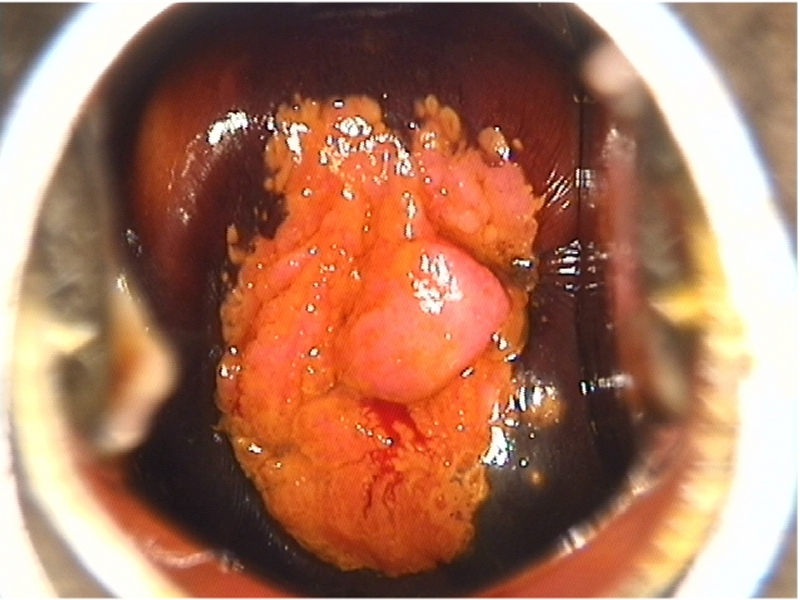

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)
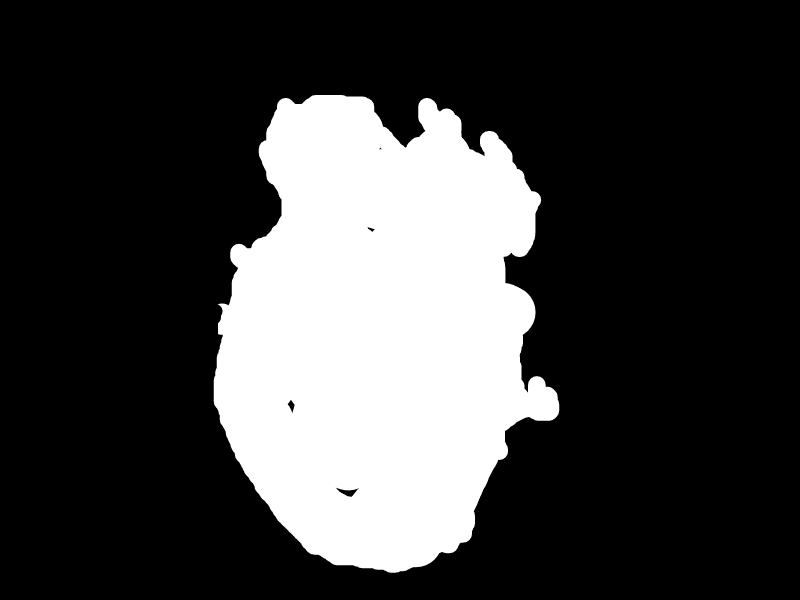

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)
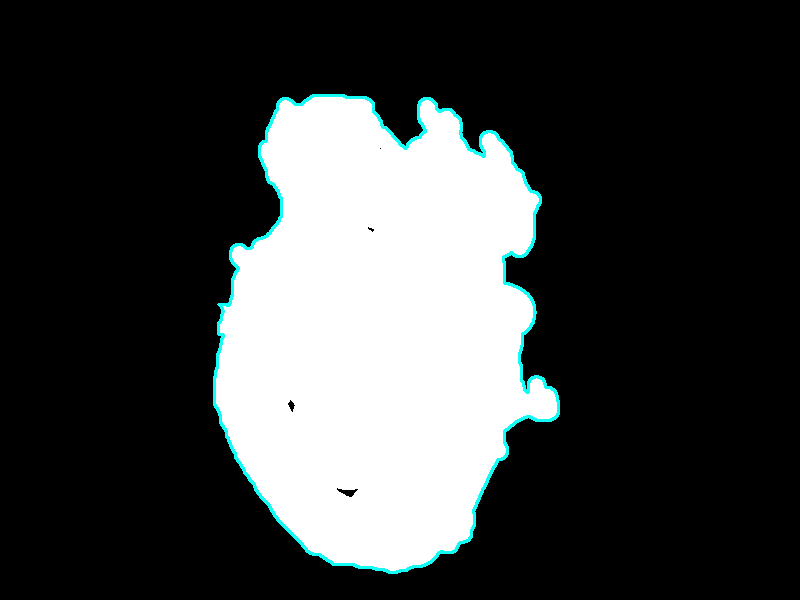

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)
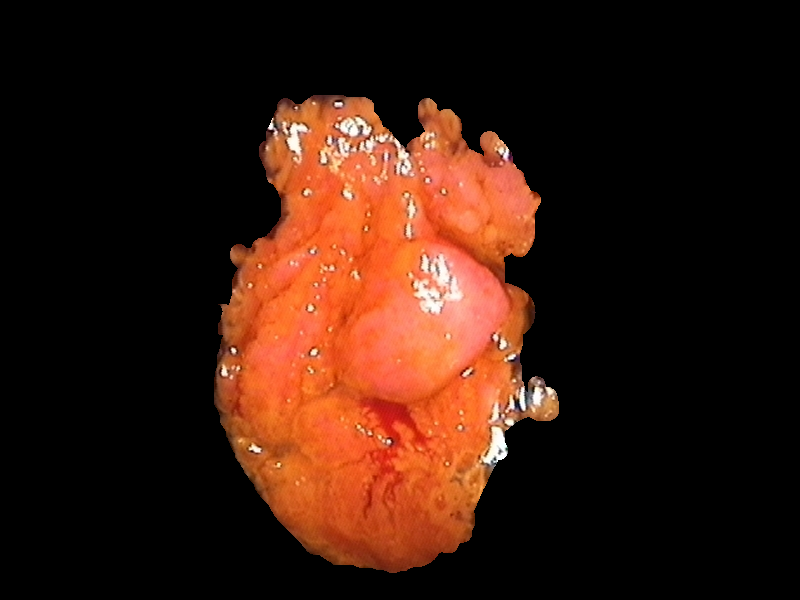

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)
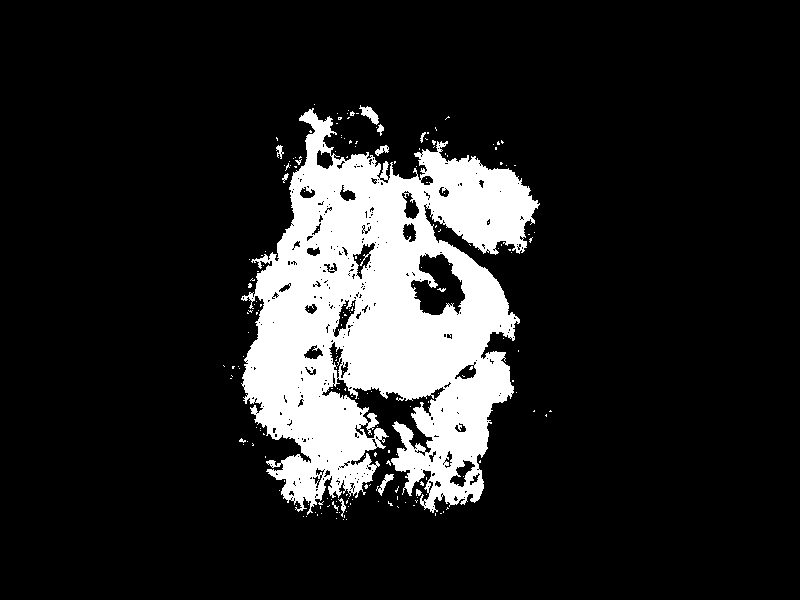

In [ ]:
from IPython.display import display, Image

# Display the original image with title "Original Image"
display(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), metadata={'id': 1, 'title': "Original Image"})

# Display the original mask with title "Original Mask"
display(mask, metadata={'id': 2, 'title': "Original Mask"})

# Display the contours from the mask with title "Contours from Mask"
display(mask1, metadata={'id': 3, 'title': "Contours from Mask"})

# Display the extracted region from the image with title "Extracted region from Image"
display(cv2.cvtColor(extracted_reg, cv2.COLOR_BGR2RGB), metadata={'id': 4, 'title': "Extracted region from Image"})

# Display the predicted mask on the extracted region with title "Predicted Mask on extracted region"
display(pred_mask, metadata={'id': 5, 'title': "Predicted Mask on extracted region"})


In [ ]:
pred_mask.shape, mask_array.shape

((600, 800), (600, 800))

In [ ]:
np.unique(pred_mask)

array([  0, 255], dtype=uint8)

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

# Calculate the confusion matrix
conf_matrix = confusion_matrix(mask_array.ravel(), pred_mask.ravel())
print(conf_matrix)

# Calculate and print the classification report
print(classification_report(mask_array.ravel(), pred_mask.ravel()))

# Calculate and print class-wise IoU
iou = (conf_matrix.diagonal() / (conf_matrix.sum(axis=1) + conf_matrix.sum(axis=0) - conf_matrix.diagonal()))
print("Class-wise IoU:", iou)

[[410353   1517]
 [  9902  58228]]
              precision    recall  f1-score   support

           0       0.98      1.00      0.99    411870
         255       0.97      0.85      0.91     68130

    accuracy                           0.98    480000
   macro avg       0.98      0.93      0.95    480000
weighted avg       0.98      0.98      0.98    480000

Class-wise IoU: [0.97292613 0.83604463]


# Testing

In [ ]:
test_image_folder = '/content/drive/MyDrive/TrainingData/ProcessedImages'
test_mask_folder = '/content/drive/MyDrive/TrainingData/Mask'

# Get sorted lists of image and mask files
test_image_files = sorted(glob.glob(os.path.join(test_image_folder, '*.jpg')))
test_mask_files = sorted(glob.glob(os.path.join(test_mask_folder, '*.png')))

# Load and preprocess images and masks
actual_mask = []
predicted_mask = []

for image_file, mask_file in zip(test_image_files, test_mask_files):
    # Load image
    img = cv2.imread(image_file)

    # Load mask
    mask = cv2.imread(mask_file, 0)  # Load as grayscale
    mask_array = np.where(mask > 127, 255, 0)
    countours, mask1 = extract_top_contours(mask_array.astype(np.uint8))

    extracted_reg = apply_region_mask(img, countours)

    flattened_img = extracted_reg.reshape(-1, 3)

    # Predict the mask
    pred_mask_flattened = model.predict(flattened_img)

    actual_mask.append(mask_array.ravel())
    predicted_mask.append(pred_mask_flattened)

actual_mask = np.concatenate(actual_mask)
predicted_mask = np.concatenate(predicted_mask)

In [ ]:
actual_mask.shape, predicted_mask.shape

((2400000,), (2400000,))

In [ ]:
np.unique(actual_mask), np.unique(predicted_mask)

(array([  0, 255]), array([  0, 255], dtype=uint8))

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

# Calculate the confusion matrix
conf_matrix = confusion_matrix(actual_mask, predicted_mask)
print(conf_matrix)

# Calculate and print the classification report
print(classification_report(actual_mask, predicted_mask))

# Calculate and print class-wise IoU
iou = (conf_matrix.diagonal() / (conf_matrix.sum(axis=1) + conf_matrix.sum(axis=0) - conf_matrix.diagonal()))
print("Class-wise IoU:", iou)

[[3666717    1876]
 [ 392653  738754]]
              precision    recall  f1-score   support

           0       0.90      1.00      0.95   3668593
         255       1.00      0.65      0.79   1131407

    accuracy                           0.92   4800000
   macro avg       0.95      0.83      0.87   4800000
weighted avg       0.93      0.92      0.91   4800000

Class-wise IoU: [0.90285518 0.65187072]


In [ ]:
def dice_coefficient(true_mask, predicted_mask):
    """
    Calculate the Dice Similarity Coefficient (DSC) between two binary masks.

    Args:
        true_mask (numpy.ndarray): Ground truth binary mask (0 or 1).
        predicted_mask (numpy.ndarray): Predicted binary mask (0 or 1).

    Returns:
        float: Dice coefficient value (between 0 and 1).
    """
    intersection = np.sum(true_mask * predicted_mask)
    union = np.sum(true_mask) + np.sum(predicted_mask)
    dice = (2.0 * intersection) / (union + 1e-8)  # Add a small epsilon to avoid division by zero
    return dice

dice_score = dice_coefficient(np.where(actual_mask > 0, 1, 0), np.where(predicted_mask > 0, 1, 0))
print(f"Dice coefficient: {dice_score:.4f}")


Dice coefficient: 0.1800


In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
# Define the paths to your image and mask folders
train_image_folder = '/content/drive/MyDrive/TrainingData/ProcessedImages'
train_mask_folder = '/content/drive/MyDrive/TrainingData/Mask'

test_image_folder = '/content/drive/MyDrive/TestingData/ProcessedImages_1'
test_mask_folder = '//content/drive/MyDrive/TestingData/Mask'

# Get sorted lists of image and mask files
train_image_files = sorted(glob.glob(os.path.join(train_image_folder, '*.jpg')))
train_mask_files = sorted(glob.glob(os.path.join(train_mask_folder, '*.png')))

test_image_files = sorted(glob.glob(os.path.join(test_image_folder, '*.jpg')))
test_mask_files = sorted(glob.glob(os.path.join(test_mask_folder, '*.png')))


print(len(train_image_files))
print(len(train_mask_files))
print(len(test_image_files))
print(len(test_mask_files))

42
42
10
10


In [ ]:
# Prepare training data
X_train = []
y_train = []

for image_file, mask_file in zip(train_image_files, train_mask_files):
    img = cv2.imread(image_file)   # Load image

    img_array = img / 255.0   # Normalize pixel values to [0, 1]
    img_array = cv2.resize(img_array, (512, 512))   #resize


    # Load mask
    mask = cv2.imread(mask_file, 0)  # Load mask as grayscale
    mask_array = mask / 255.0  # Normalize pixel values to [0, 1]
    mask_array = mask_array.astype(np.float32)
    # Resize mask to (256, 256, 1)
    mask_array = cv2.resize(mask_array, (512, 512))
    mask_array = np.expand_dims(mask_array, axis=-1)  # Add a channel dimension
    # Apply threshold to create binary mask
    threshold = 0.5  # Adjust threshold if needed
    mask_array = np.where(mask_array > threshold, 1, 0)  # Set pixels above threshold to 1

    flattened_image = img_array.reshape(-1, 3)
    binary_mask = mask_array.ravel()


    X_train.append(flattened_image)
    y_train.append(binary_mask)

X_train = np.vstack(X_train)
y_train = np.concatenate(y_train, axis = 0)

print(X_train.shape, y_train.shape)

(11010048, 3) (11010048,)


In [ ]:
clf = RandomForestClassifier(max_depth=10, min_samples_leaf=10, min_samples_split=16, n_estimators=10)  #Define classifier
clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, min_samples_leaf=10, min_samples_split=16,
                       n_estimators=10)

In [ ]:
# Load and preprocess images and masks
actual_mask = []
predicted_mask = []

for image_file, mask_file in zip(test_image_files, test_mask_files):
    # Load image
    img = cv2.imread(image_file)

    # Load mask
    mask = cv2.imread(mask_file, 0)  # Load as grayscale
    mask_array = np.where(mask > 127, 255, 0)
    countours, mask1 = extract_top_contours(mask_array.astype(np.uint8))

    extracted_reg = apply_region_mask(img, countours)

    flattened_img = extracted_reg.reshape(-1, 3)

    # Predict the mask
    pred_mask_flattened = clf.predict(flattened_img)
    mask_array = np.where(mask_array > 127, 1, 0)

    actual_mask.append(mask_array.ravel())
    predicted_mask.append(pred_mask_flattened)

actual_mask = np.concatenate(actual_mask)
predicted_mask = np.concatenate(predicted_mask)

In [ ]:
print(actual_mask.shape, predicted_mask.shape)
print(np.unique(actual_mask), np.unique(predicted_mask))

(4800000,) (4800000,)
[0 1] [0 1]


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

# Calculate the confusion matrix
conf_matrix = confusion_matrix(actual_mask, predicted_mask)
print(conf_matrix)

# Calculate and print the classification report
print(classification_report(actual_mask, predicted_mask))

# Calculate and print class-wise IoU
iou = (conf_matrix.diagonal() / (conf_matrix.sum(axis=1) + conf_matrix.sum(axis=0) - conf_matrix.diagonal()))
print("Class-wise IoU:", iou)

[[3666928    1665]
 [1019355  112052]]
              precision    recall  f1-score   support

           0       0.78      1.00      0.88   3668593
           1       0.99      0.10      0.18   1131407

    accuracy                           0.79   4800000
   macro avg       0.88      0.55      0.53   4800000
weighted avg       0.83      0.79      0.71   4800000

Class-wise IoU: [0.78220322 0.09889222]


In [ ]:
dice_score = dice_coefficient(actual_mask, predicted_mask)
print(f"Dice coefficient: {dice_score:.4f}")

Dice coefficient: 0.1800
